# Transfer Learning Image Classification
## Classifying NBA teams from images of NBA player profile pictures

The following notebook trains a multiclass image classification model using limited data with transfer learning.

Specifically, we will be training an image classifier to classify NBA player profile pictures to their corresponding NBA team.

## Global Configurations

In [1]:
import os
import torch

from IPython.display import Image

In [2]:
TEAMS_URL = 'https://www.nba.com/teams'
TEAMS_LINK_CLASS = 'TeamFigure_tfLinks__gwWFj'

In [3]:
DATA_DIR = 'nba_player_photos'

In [4]:
SEED = None
if SEED is not None:
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  print(f'Random seed: {SEED}')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data Preparation

### Scraping the data

Data will be NBA player profile pictures scraped from www.nba.com.
* There are **30** classes (NBA teams)
* There are **15-18** items per class (NBA players)
* Photos are **1040x760** pixels

**Note:** Depending on when the data is scraped, players may have since been traded and are on new teams from their original photos, thus introducing dirtiness to the data. For clean data corresponding to the beginning of the 2022-23 season, [download]() the zip file from GitHub.

In [6]:
import requests
import shutil

from bs4 import BeautifulSoup
from pathlib import Path
from tqdm.notebook import tqdm

In [7]:
def get_teams_info():
  html = requests.get(TEAMS_URL).content
  soup = BeautifulSoup(html, 'html.parser')
  teams = []
  for team_links in soup.find_all('div', {'class': TEAMS_LINK_CLASS}):
    profile_link = next(team_links.children)
    link_parts = profile_link['href'].split('/')
    team_name, team_id = link_parts[3], link_parts[2]
    teams.append([team_name, team_id])
  return teams

In [8]:
teams_info = get_teams_info()
team_names = list(map(lambda team: team[0], teams_info))

Comment below to prevent clearing the `DATA_DIR` and forcing a fresh download

In [9]:
if Path(DATA_DIR).exists():
  shutil.rmtree(DATA_DIR)

Download photos to `DATA_DIR`

In [10]:
if Path(DATA_DIR).exists():
  print('Already downloaded all photos')
else:
  pbar = tqdm(teams_info)
  for team_name, team_id in pbar:
    pbar.set_description(f'Downloading {team_name} photos')
    Path(os.path.join(DATA_DIR, team_name)).mkdir(parents=True, exist_ok=True)
    team_url = f'https://www.nba.com/team/{team_id}/{team_name}'
    roster_table = None
    while roster_table == None: # loop in case of unsuccessful get request
      html = requests.get(team_url).content
      soup = BeautifulSoup(html, 'html.parser')
      roster_table = soup.find('table')
    roster_rows = roster_table.find_all('tr')
    for player_row in roster_rows[1:]: # skip header row
      link_parts = player_row.find('a')['href'].split('/')
      player_name, player_id = link_parts[3], link_parts[2]
      player_pic_url = \
        f'https://cdn.nba.com/headshots/nba/latest/1040x760/{player_id}.png'
      img_data = requests.get(player_pic_url).content
      img_path = os.path.join(DATA_DIR, team_name, f'{player_name}.png')
      with open(img_path, 'wb') as f:
        f.write(img_data)
    if pbar.n + 1 == len(teams_info):
      pbar.set_description('Downloaded all photos')

  0%|          | 0/30 [00:00<?, ?it/s]

### Creating train/test data split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
TEST_SIZE = 0.15

In [13]:
TRAIN_PATH = os.path.join(DATA_DIR, 'train')
TEST_PATH = os.path.join(DATA_DIR, 'test')

In [14]:
if Path(TRAIN_PATH).exists() and Path(TEST_PATH).exists():
  print('Already split data into train/test')
else:
  train_paths = []
  test_paths = []
  for root, _, files in os.walk(DATA_DIR):
    if len(files) == 0:
      continue
    label = root.split('/')[1]
    train_files, test_files = train_test_split(
        files, test_size=TEST_SIZE, random_state=SEED)
    train_paths += list(map(lambda file: os.path.join(root, file), train_files))
    test_paths += list(map(lambda file: os.path.join(root, file), test_files))

Move photos into `train` and `test` directories and remove remaining directories

In [15]:
if Path(TRAIN_PATH).exists() and Path(TEST_PATH).exists():
  print('Already moved photos into train/test directories')
else:
  Path(TRAIN_PATH).mkdir(exist_ok=True)
  Path(TEST_PATH).mkdir(exist_ok=True)
  for file_path in train_paths:
    team_name = file_path.split('/')[1]
    team_train_path = os.path.join(TRAIN_PATH, team_name)
    if not os.path.exists(team_train_path):
      os.mkdir(team_train_path)
    filename = file_path.split('/')[-1]
    shutil.move(file_path, os.path.join(team_train_path, filename))
  for file_path in test_paths:
    team_name = file_path.split('/')[1]
    team_test_path = os.path.join(TEST_PATH, team_name)
    if not os.path.exists(team_test_path):
      os.mkdir(team_test_path)
    filename = file_path.split('/')[-1]
    shutil.move(file_path, os.path.join(team_test_path, filename))
  for team_name in team_names:
    shutil.rmtree(os.path.join(DATA_DIR, team_name))

#### Sample training observation

In [16]:
sample_team_name = teams_info[0][0]
sample_team_path = os.path.join(TRAIN_PATH, sample_team_name)
sample_player_file = os.listdir(sample_team_path)[0]
sample_player_path = os.path.join(sample_team_path, f'{sample_player_file}')

observation: sam-hauser.png


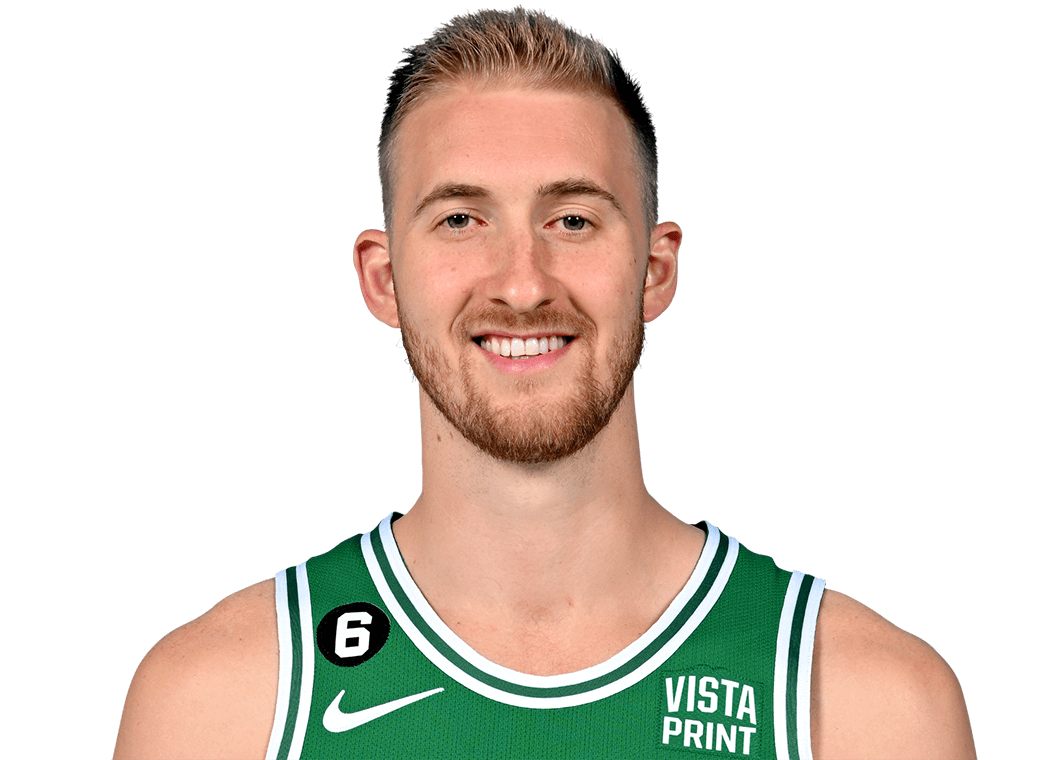

class: celtics


In [17]:
print(f'observation: {sample_player_file}')
display(Image(sample_player_path))
print(f'class: {sample_team_name}')

### Create `DataLoaders` for dataset

In [18]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [19]:
BATCH_SIZE = 32
NUM_WORKERS = 1

Define ImageNet transform

In [20]:
# ImageNet normalize transform as coded in
# https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198
normalize_imagenet = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

In [21]:
transform_imagenet = transforms.Compose([
  transforms.Resize(size=(224, 224)),
  transforms.ToTensor(),
  normalize_imagenet
])

Create `dataset_train` and `dataset_test`

In [22]:
dataset_train = datasets.ImageFolder(
    root=TRAIN_PATH,
    transform=transform_imagenet)
dataset_test = datasets.ImageFolder(
    root=TEST_PATH,
    transform=transform_imagenet)

Create `DataLoaders`

In [23]:
dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True)
dataloader_test = DataLoader(
    dataset=dataset_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False)

## Model Fitting